Shift work entails a lot of quirks. For one thing, you might end up becoming a night owl like me. On night shifts, I typically work from 21:30 to 05:30; on unlucky days when I have to work twelve hours, I'm at work from 17:30 to 05:30 the next day. Quite naturally, working schedules---otherwise referred to as the DA6 document---is at the center of everyone's attention at the end of every month. The schedule table contains information on who works when, for how many hours, on which shift. 

So far, the DA6 has always been generated by hand. However, I thought this process could be automated to a certain extent, as long as they aren't too many complications such as sick leaves or other emergencies. So here is my preliminary jab at DA6 auto-generation. 

# Setup

Let's import some modules for the today's task. We will be using `matplotlib` for a simple visualization; the important modules are the ones from `collections`, which we will be utilizing to more easily manipulate data structures.

In [1]:
from datetime import datetime
from calendar import monthrange
from collections import deque, Counter
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
preference = [1, 8, 9, 10]
constraint = []
now = datetime.now()
_, N_DAYS = monthrange(now.year, now.month)

In [3]:
def check_collision(preference, constraint):
    preference, constraint = set(preference), set(constraint)
    return len(preference.union(constraint)) != len(preference) + len(constraint)

In [4]:
check_collision(preference, constraint)

False

In [5]:
def create_draft(preference, constraint):
    if check_collision(preference, constraint):
        print("Constraint will override preference")
    draft = [None] * N_DAYS
    for i in range(len(draft)):
        # 1 = work, 0 = off
        if i + 1 in preference:
            draft[i] = 0
        if i + 1 in constraint:
            draft[i] = 1
    return draft

In [6]:
draft = create_draft(preference, constraint)
print(draft)

[0, None, None, None, None, None, None, 0, 0, 0, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [7]:
def populate_schedule(start, draft, debug=False):
    res = set()
    queue = deque([(start, draft)])
    while queue:
        date, draft = queue.popleft()
        if date == len(draft):
            debug and print(draft)
            if (check_total(draft)
               and check_ones(draft)):
                res.add(tuple(draft))
            continue
        n_workdays = sum(draft[max(0, date - 2) : date])
        queue += (
            off_next(date, draft, debug)
            if n_workdays > 0
            else work_next(date, draft, debug)
        )
    return res

In [8]:
def check_total(draft):
    return N_DAYS / 2 - 2 <= sum(draft) <= N_DAYS / 2 + 2

In [9]:
def fill_next(date, draft, is_off, debug=False):
    res = []
    is_work = 1 - is_off
    for n_days in [2, 3]:
        flag = True
        next_draft = draft.copy()
        limit = min(N_DAYS, date + n_days)
        for day in range(date, limit):
            if next_draft[day] == is_off:
                flag = False
                break
            next_draft[day] = is_work
        if limit != N_DAYS and next_draft[limit] == is_work:
            flag = False
        if flag:
            debug and print(next_draft)
            res.append((limit, next_draft))
    return res

In [10]:
def work_next(date, draft, debug=False):
    return fill_next(date, draft, 0, debug=debug)

In [11]:
def off_next(date, draft, debug=False):
    return fill_next(date, draft, 1, debug=debug)

In [12]:
def check_ones(draft):
    for i in range(0, len(draft) - 2):
        if draft[i] == 0 and draft[i + 1] == 1 and draft[i + 2] == 0:
            return False
        if draft[i] == 1 and draft[i + 1] == 0 and draft[i + 2] == 1:
            return False
    return True

In [13]:
def check_overwork(draft):
    # past 8 days
    queue = deque(draft[:8])
    for i in range(8, len(draft)):
        # overwork: 6 of 8 days
        if sum(queue) > 6:
            return False
        queue.popleft()
        queue.append(draft[i])
    return True

In [14]:
def check_consecutives(draft):
    queue = deque(draft[:4])
    for i in range(4, len(draft)):
        if not (0 < sum(queue) < 4):
            return False
        queue.popleft()
        queue.append(draft[i])
    if 0 < sum(queue) < 4:
        return True
    return False

In [15]:
def find_start(preference):
    for i in range(1, N_DAYS):
        if i not in preference:
            return i - 1

In [16]:
find_start(preference)

1

In [17]:
def generate_schedule(preference, constraint):
    '''
    3 days off: work on 1st
    2 days off: either work or rest on 1st
    1 day off: need off on 1st
    '''
    for info in [preference, constraint]:
        not info and info.append(0)
    start = find_start(preference)
    draft1 = create_draft(preference, constraint)
    res = populate_schedule(start, draft1)
    start += 1
    if start not in constraint:
        preference.append(start)
        draft2 = create_draft(preference, constraint)
        res2 = populate_schedule(start, draft2)
        res = list(res.union(res2))
    else:
        res = list(res)
    res.sort(key=lambda x: sum(x))
    return res

In [18]:
res = generate_schedule(preference, constraint)
len(res)

260

In [19]:
for schedule in res:
    print(schedule)

(0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1)
(0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0)
(0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1)
(0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1)
(0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0)
(0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0)
(0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0)
(0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1)
(0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0)
(0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1)
(0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,

In [20]:
def plot_freq(res):
    counter = Counter([sum(draft) for draft in res])
    labels = counter.keys()
    sizes = counter.values()
    plt.pie(sizes, labels=labels, autopct="%1.1f%%")
    plt.show()

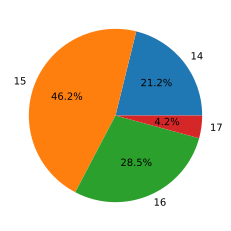

In [21]:
plot_freq(res)

In [22]:
def invert(schedule):
    return [1 - x for x in schedule]

In [23]:
print(invert(res[0]))

[1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0]


In [32]:
class Person:
    def __init__(self, preference, constraint):
        self.preference = preference
        self.constraint = constraint
        
    def merge(self, other_preference):
        for date in other_preference:
            if date not in self.constraint:
                self.constraint.append(date)
        print(f"Merged constraint: {self.constraint}")
    
    def build_schedule(self, random_seed):
        while True:
            res = generate_schedule(self.preference, self.constraint)
            if res:
                self.schedules = res
                break
            print(f"Popped: {self.constraint.pop()}")
        length = len(self.schedules)
        print(f"Total drafts: {length}")
        self.schedule = self.schedules[random_seed % length]
        print(f"Schedule: {self.schedule}, Total: {sum(self.schedule)}")
    
    def invert(self, person):
        self.schedule = invert(person.schedule)
        print(f"Schedule: {self.schedule}, Total: {sum(self.schedule)}")

In [33]:
def build_da6(person1, person2, random_seed=42):
    '''
    person1's preference = person2's constraint
    person2's preference = person1's constraint
    '''
    person1.merge(person2.preference)
    person1.build_schedule(random_seed)
    person2.invert(person1)

In [34]:
person1 = Person([1], [9, 8])
person2 = Person([15, 27, 28], [])
build_da6(person1, person2)

Merged constraint: [9, 8, 15, 27, 28]
Total drafts: 213
Schedule: (0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0), Total: 15
Schedule: [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1], Total: 16


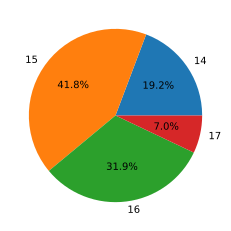

In [35]:
plot_freq(person1.schedules)